# Market Regime Classification

Define periods of bull, bear, and flat markets based on price movements over the prediction horizon (6-21 days).

In [2]:
import pandas as pd
import numpy as np 
from matplotlib import pyplot as plt 

df = pd.read_csv("./data/downloaded/SVXY.csv")

df.rename(columns={"Unnamed: 0": "date"}, inplace=True)
df.set_index("date", inplace=True)
df.index = pd.to_datetime(df.index)
df.head()

,open,high,low,close,volume
date,,,,,
2011-10-04,39.490,42.100,39.30,10.5250,20300
2011-10-05,43.530,45.640,43.45,11.3475,8900
2011-10-06,45.430,46.330,44.80,11.5825,5600
2011-10-07,47.185,47.185,44.78,11.6725,18200
2011-10-10,47.500,48.600,47.40,12.1500,15000


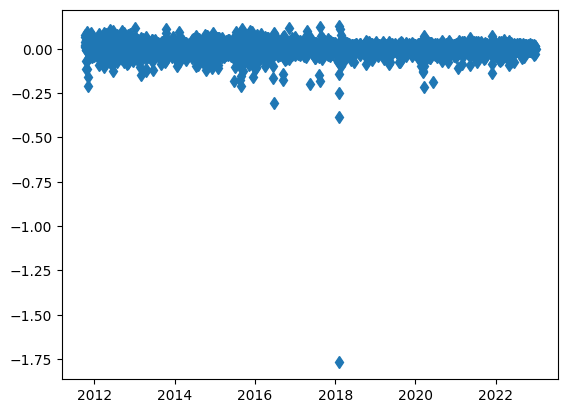

In [3]:
import random

N = 100

start = random.randint(0, len(df.index) - N - 1)
x = df.index
y = df.close

y_star = np.log(y.to_numpy()[1:]) - np.log(y.to_numpy()[:-1]) 

plt.plot(x[1:], y_star, "d")

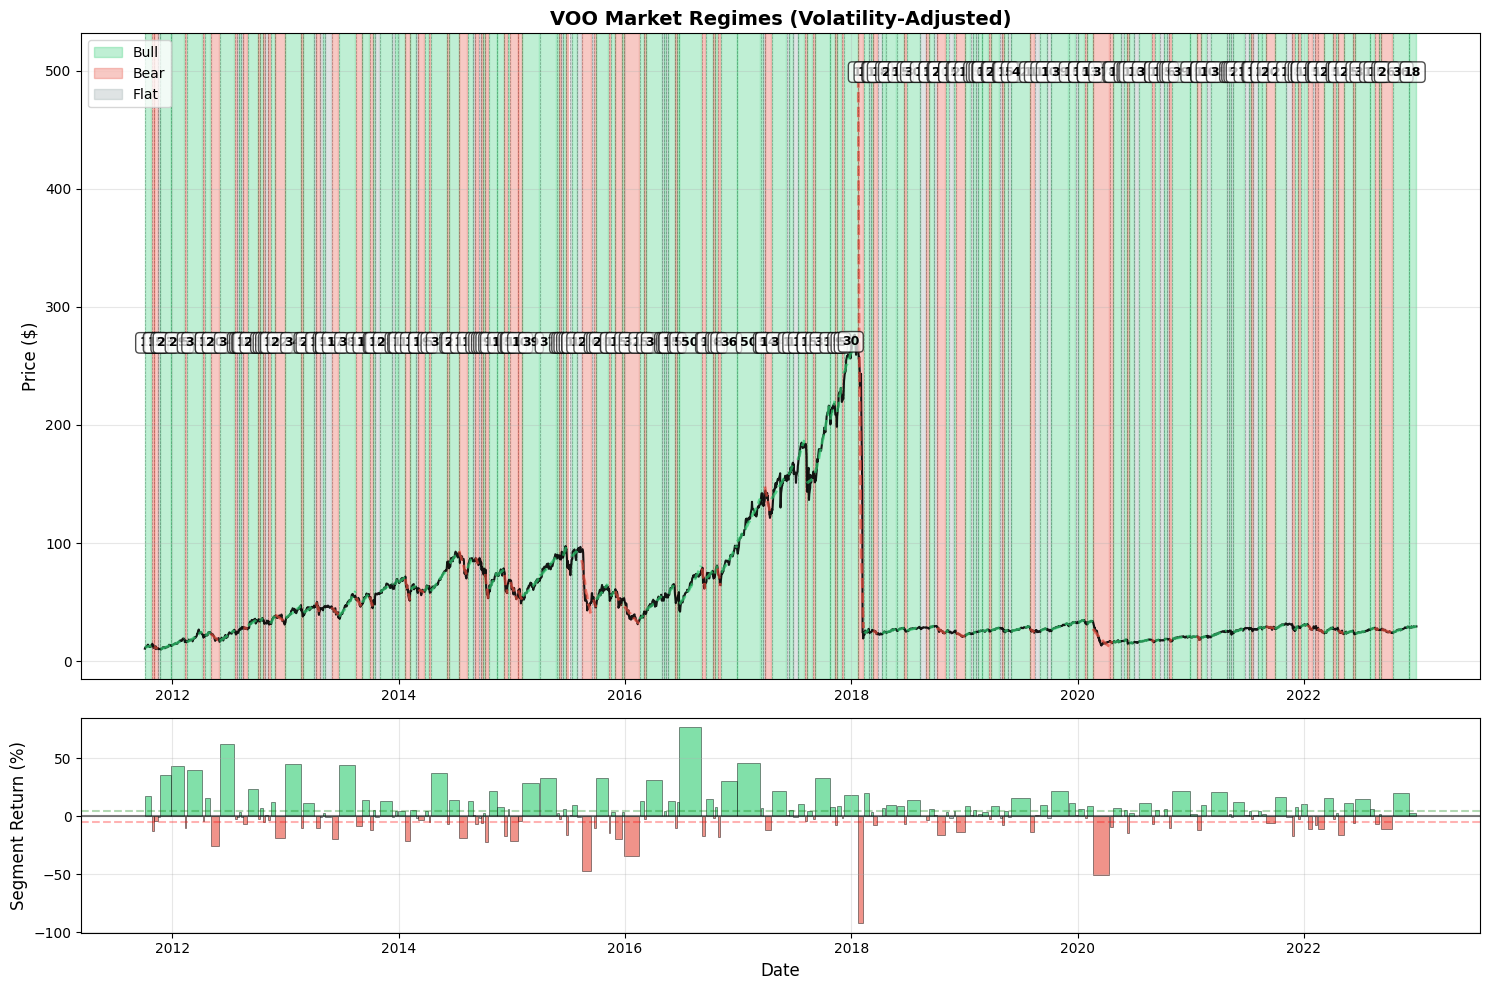

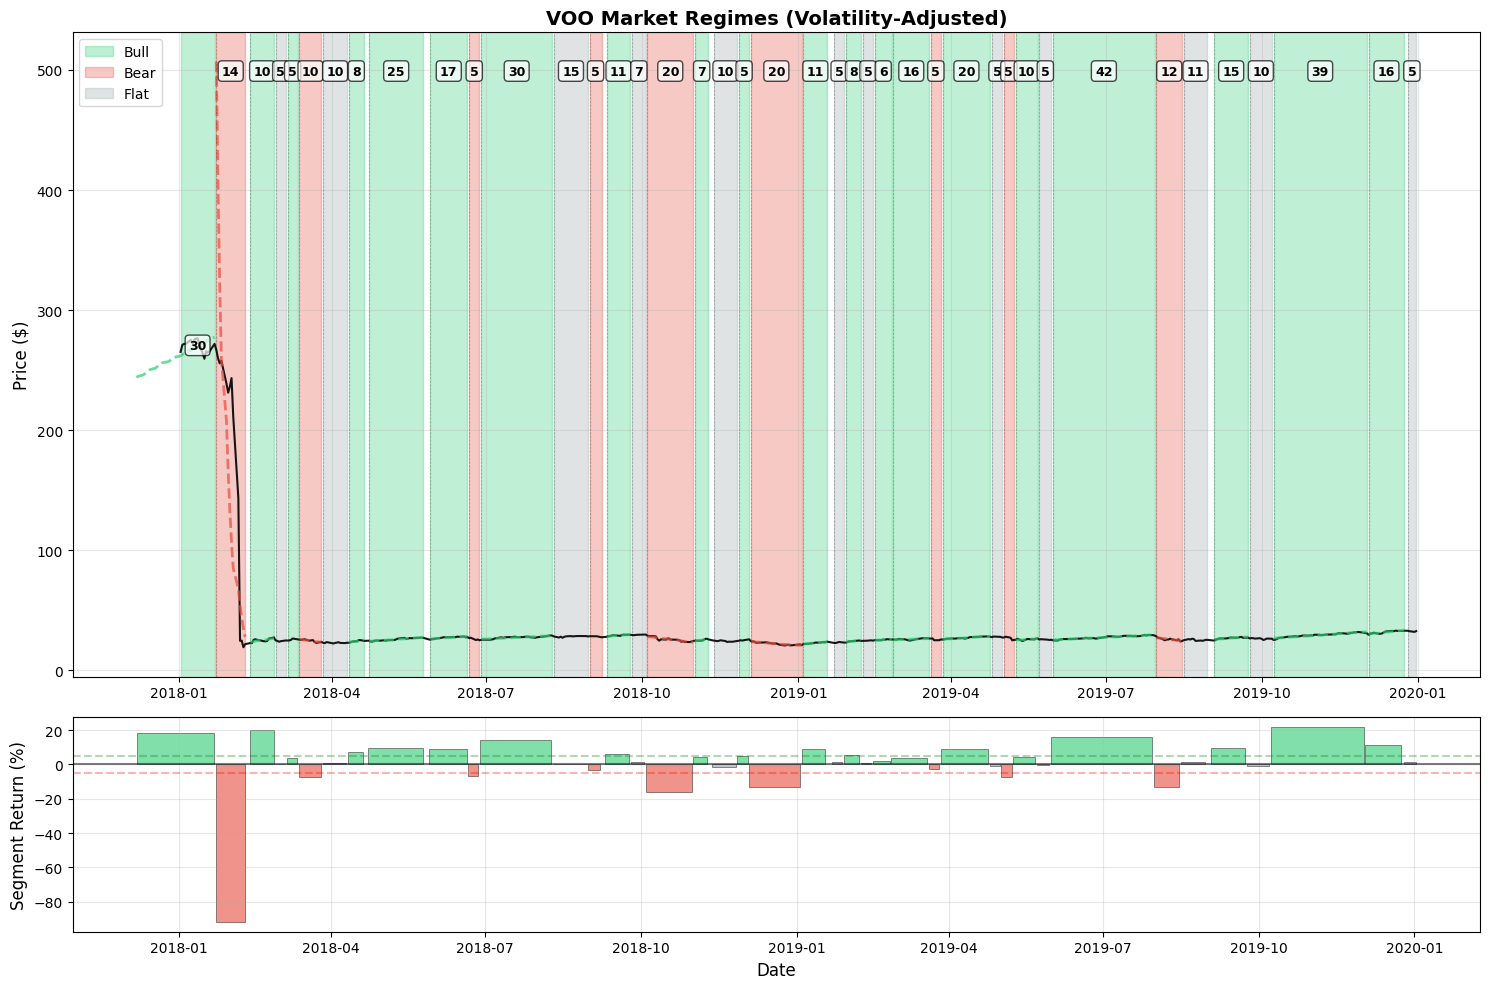

Market Regime Analysis (Volatility-Adjusted)

Total segments: 218
Average segment duration: 13.0 days
Segments per year: 19.4

By Regime Type:

BULL:
  Count: 102
  Avg duration: 17.7 days
  Avg return: 14.1%
  Total days: 1807 (63.9%)

BEAR:
  Count: 72
  Avg duration: 9.9 days
  Avg return: -12.1%
  Total days: 712 (25.2%)

FLAT:
  Count: 44
  Avg duration: 7.1 days
  Avg return: 0.0%
  Total days: 311 (11.0%)


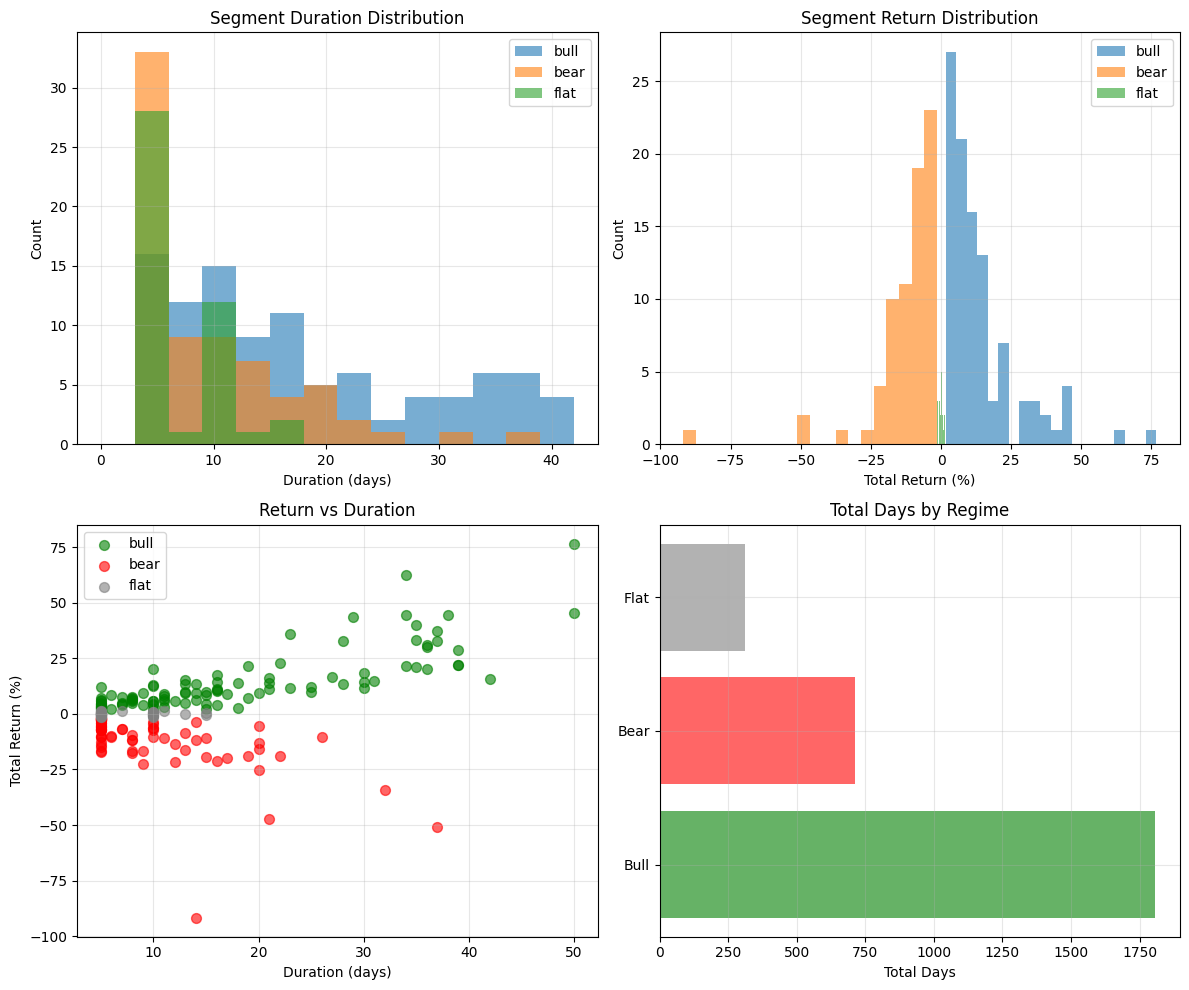


Example segments (last 10):
2022-04-21 to 2022-05-09: bear  (13d, return= -16.3%)
2022-05-10 to 2022-06-08: bull  (21d, return=  11.3%)
2022-06-09 to 2022-06-15: bear  ( 5d, return=  -5.7%)
2022-06-16 to 2022-08-01: bull  (31d, return=  15.0%)
2022-08-02 to 2022-08-16: bull  (11d, return=   6.7%)
2022-08-17 to 2022-08-30: bear  (10d, return=  -6.3%)
2022-08-31 to 2022-09-07: bull  ( 5d, return=   1.6%)
2022-09-08 to 2022-10-13: bear  (26d, return= -10.5%)
2022-10-14 to 2022-12-05: bull  (36d, return=  20.4%)
2022-12-06 to 2022-12-30: bull  (18d, return=   2.8%)


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from datetime import datetime

def detect_regimes_adaptive(df, min_window=3, max_window=30, r2_threshold=0.75, 
                          volatility_factor=2.0, min_trend_strength=5.0):
    """
    Detect market regimes using adaptive windows with volatility-adjusted thresholds.
    
    Parameters:
    - min_window: Minimum regime duration (3 days)
    - max_window: Maximum window to consider
    - r2_threshold: Base R² threshold (relaxed to allow for volatility)
    - volatility_factor: How many standard deviations for trend break
    - min_trend_strength: Minimum cumulative return (%) to qualify as bull/bear
    
    Returns:
    - DataFrame with regime classifications and segments list
    """
    df = df.copy()
    df['log_price'] = np.log(df['close'])
    df['returns'] = df['log_price'].diff()
    
    segments = []
    i = 0
    
    while i < len(df):
        # Handle end of data
        if i >= len(df) - min_window:
            remaining = len(df) - i
            if remaining > 0:
                # Simple classification for remaining data
                total_return = (df['close'].iloc[-1] / df['close'].iloc[i] - 1) * 100
                
                if abs(total_return) < min_trend_strength:
                    regime = 'flat'
                elif total_return > 0:
                    regime = 'bull'
                else:
                    regime = 'bear'
                
                segments.append({
                    'start': i,
                    'end': len(df) - 1,
                    'start_date': df.index[i],
                    'end_date': df.index[-1],
                    'regime': regime,
                    'total_return': total_return,
                    'duration': remaining
                })
            break
        
        # Find the best window by looking for trend consistency
        best_window = min_window
        
        for window in range(min_window, min(max_window + 1, len(df) - i + 1)):
            # Get window data
            window_prices = df['close'].iloc[i:i+window].values
            window_log_prices = df['log_price'].iloc[i:i+window].values
            
            # Fit regression
            x = np.arange(window)
            slope, intercept, r_value, _, _ = stats.linregress(x, window_log_prices)
            r2 = r_value**2
            
            # Calculate trend line values
            trend_line = slope * x + intercept
            
            # Calculate deviations from trend
            deviations = window_log_prices - trend_line
            volatility = np.std(deviations)
            
            # Check if price has broken the trend channel significantly
            if window > min_window:
                # Current deviation from trend
                current_deviation = abs(deviations[-1])
                
                # Trend break conditions:
                # 1. Price moves beyond volatility bands
                # 2. R² drops significantly (indicates trend change)
                # 3. Cumulative return reverses significantly
                
                trend_broken = (
                    current_deviation > volatility * volatility_factor or
                    r2 < r2_threshold * 0.8  # 20% drop from threshold
                )
                
                if trend_broken:
                    break
            
            best_window = window
        
        # Calculate regime for the segment
        segment_return = (df['close'].iloc[i + best_window - 1] / df['close'].iloc[i] - 1) * 100
        
        if abs(segment_return) < min_trend_strength:
            regime = 'flat'
        elif segment_return > 0:
            regime = 'bull'
        else:
            regime = 'bear'
        
        # Store segment
        segments.append({
            'start': i,
            'end': i + best_window - 1,
            'start_date': df.index[i],
            'end_date': df.index[i + best_window - 1],
            'regime': regime,
            'total_return': segment_return,
            'duration': best_window
        })
        
        # Move to next segment
        i += best_window
    
    # Post-process: merge similar consecutive segments
    segments = merge_similar_segments(segments, df, min_trend_strength)
    
    # Apply segments to dataframe
    df['regime'] = 'flat'
    df['segment_id'] = -1
    
    for idx, seg in enumerate(segments):
        df.iloc[seg['start']:seg['end']+1, df.columns.get_loc('regime')] = seg['regime']
        df.iloc[seg['start']:seg['end']+1, df.columns.get_loc('segment_id')] = idx
    
    return df, segments

def merge_similar_segments(segments, df, min_trend_strength):
    """Merge consecutive segments with similar regimes or weak trends"""
    if len(segments) <= 1:
        return segments
    
    merged = []
    i = 0
    
    while i < len(segments):
        current = segments[i]
        
        # Look for segments to merge
        j = i + 1
        while j < len(segments) and j - i < 5:  # Don't merge too many segments
            next_seg = segments[j]
            
            # Conditions for merging:
            # 1. Same regime
            # 2. Both are weak trends (could be consolidated into flat)
            # 3. Combined segment maintains reasonable characteristics
            
            same_regime = current['regime'] == next_seg['regime']
            both_weak = (abs(current['total_return']) < min_trend_strength * 1.5 and 
                        abs(next_seg['total_return']) < min_trend_strength * 1.5)
            
            if same_regime or both_weak:
                # Check combined characteristics
                combined_return = (df['close'].iloc[next_seg['end']] / 
                                 df['close'].iloc[current['start']] - 1) * 100
                combined_duration = next_seg['end'] - current['start'] + 1
                
                # Don't create segments that are too long
                if combined_duration <= 40:
                    # Update current to include next
                    current = {
                        'start': current['start'],
                        'end': next_seg['end'],
                        'start_date': current['start_date'],
                        'end_date': next_seg['end_date'],
                        'regime': 'flat' if abs(combined_return) < min_trend_strength else 
                                 ('bull' if combined_return > 0 else 'bear'),
                        'total_return': combined_return,
                        'duration': combined_duration
                    }
                    j += 1
                else:
                    break
            else:
                break
        
        merged.append(current)
        i = j
    
    return merged

def plot_adaptive_regimes_v2(df, segments, symbol='', start_date=None, end_date=None):
    """Plot price with regime segments and trend channels"""
    plot_df = df.copy()
    if start_date:
        plot_df = plot_df[plot_df.index >= start_date]
    if end_date:
        plot_df = plot_df[plot_df.index <= end_date]
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), height_ratios=[3, 1])
    
    # Plot 1: Price with regime coloring
    ax1.plot(plot_df.index, plot_df['close'], color='black', linewidth=1.5, alpha=0.9)
    
    colors = {'bull': '#2ECC71', 'bear': '#E74C3C', 'flat': '#95A5A6'}
    
    # Plot segments with trend lines
    for seg in segments:
        if seg['end_date'] >= plot_df.index[0] and seg['start_date'] <= plot_df.index[-1]:
            # Clip segment to plot range
            seg_start = max(seg['start_date'], plot_df.index[0])
            seg_end = min(seg['end_date'], plot_df.index[-1])
            
            # Color background
            ax1.axvspan(seg_start, seg_end, alpha=0.3, color=colors[seg['regime']])
            
            # Add trend line for non-flat segments
            if seg['regime'] != 'flat' and seg['duration'] > 5:
                seg_data = df.iloc[seg['start']:seg['end']+1]
                x = np.arange(len(seg_data))
                y = np.log(seg_data['close'].values)
                slope, intercept = np.polyfit(x, y, 1)
                trend_line = np.exp(slope * x + intercept)
                
                ax1.plot(seg_data.index, trend_line, color=colors[seg['regime']], 
                        linewidth=2, alpha=0.7, linestyle='--')
            
            # Segment boundary
            if seg['start_date'] >= plot_df.index[0]:
                ax1.axvline(x=seg['start_date'], color='black', linestyle='--', 
                           alpha=0.3, linewidth=0.5)
            
            # Add duration text
            if seg_start < seg_end:  # Make sure segment is visible
                # Calculate position for text (middle of segment, at top of price range)
                seg_middle = seg_start + (seg_end - seg_start) / 2
                
                # Get y position - place text at a consistent height relative to the plot
                y_range = ax1.get_ylim()
                y_position = y_range[0] + (y_range[1] - y_range[0]) * 0.95
                
                # Add text with duration
                ax1.text(seg_middle, y_position, str(seg['duration']), 
                        horizontalalignment='center', verticalalignment='top',
                        fontsize=9, fontweight='bold', color='black',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    
    ax1.set_title(f'{symbol} Market Regimes (Volatility-Adjusted)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Legend
    bull_patch = mpatches.Patch(color=colors['bull'], alpha=0.3, label='Bull')
    bear_patch = mpatches.Patch(color=colors['bear'], alpha=0.3, label='Bear')
    flat_patch = mpatches.Patch(color=colors['flat'], alpha=0.3, label='Flat')
    ax1.legend(handles=[bull_patch, bear_patch, flat_patch], loc='upper left')
    
    # Plot 2: Segment returns
    segment_df = pd.DataFrame(segments)
    for _, seg in segment_df.iterrows():
        if seg['end_date'] >= plot_df.index[0] and seg['start_date'] <= plot_df.index[-1]:
            seg_center = seg['start_date'] + (seg['end_date'] - seg['start_date']) / 2
            color = colors[seg['regime']]
            ax2.bar(seg_center, seg['total_return'], 
                   width=(seg['end_date'] - seg['start_date']).days,
                   color=color, alpha=0.6, edgecolor='black', linewidth=0.5)
    
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax2.axhline(y=5, color='green', linestyle='--', alpha=0.3)
    ax2.axhline(y=-5, color='red', linestyle='--', alpha=0.3)
    ax2.set_ylabel('Segment Return (%)', fontsize=12)
    ax2.set_xlabel('Date', fontsize=12)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def analyze_regimes_v2(segments, df):
    """Analyze regime characteristics"""
    seg_df = pd.DataFrame(segments)
    
    print("Market Regime Analysis (Volatility-Adjusted)")
    print("=" * 50)
    
    print(f"\nTotal segments: {len(segments)}")
    print(f"Average segment duration: {seg_df['duration'].mean():.1f} days")
    print(f"Segments per year: {len(segments) / (len(df) / 252):.1f}")
    
    print("\nBy Regime Type:")
    for regime in ['bull', 'bear', 'flat']:
        regime_segs = seg_df[seg_df['regime'] == regime]
        if len(regime_segs) > 0:
            print(f"\n{regime.upper()}:")
            print(f"  Count: {len(regime_segs)}")
            print(f"  Avg duration: {regime_segs['duration'].mean():.1f} days")
            print(f"  Avg return: {regime_segs['total_return'].mean():.1f}%")
            print(f"  Total days: {regime_segs['duration'].sum()} ({regime_segs['duration'].sum()/len(df)*100:.1f}%)")
    
    # Duration and return distributions
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 10))
    
    # Duration histogram
    for regime in ['bull', 'bear', 'flat']:
        durations = seg_df[seg_df['regime'] == regime]['duration']
        if len(durations) > 0:
            ax1.hist(durations, alpha=0.6, label=regime, bins=range(0, 45, 3))
    ax1.set_xlabel('Duration (days)')
    ax1.set_ylabel('Count')
    ax1.set_title('Segment Duration Distribution')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Return distribution
    for regime in ['bull', 'bear', 'flat']:
        returns = seg_df[seg_df['regime'] == regime]['total_return']
        if len(returns) > 0:
            ax2.hist(returns, alpha=0.6, label=regime, bins=20)
    ax2.set_xlabel('Total Return (%)')
    ax2.set_ylabel('Count')
    ax2.set_title('Segment Return Distribution')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Return vs Duration scatter
    colors_map = {'bull': 'green', 'bear': 'red', 'flat': 'gray'}
    for regime in ['bull', 'bear', 'flat']:
        regime_segs = seg_df[seg_df['regime'] == regime]
        if len(regime_segs) > 0:
            ax3.scatter(regime_segs['duration'], regime_segs['total_return'],
                       color=colors_map[regime], alpha=0.6, label=regime, s=50)
    ax3.set_xlabel('Duration (days)')
    ax3.set_ylabel('Total Return (%)')
    ax3.set_title('Return vs Duration')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # Timeline
    ax4.barh(['Bull', 'Bear', 'Flat'], 
             [seg_df[seg_df['regime'] == r]['duration'].sum() for r in ['bull', 'bear', 'flat']],
             color=['green', 'red', 'gray'], alpha=0.6)
    ax4.set_xlabel('Total Days')
    ax4.set_title('Total Days by Regime')
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Test with 5% threshold as requested
df_adaptive, segments = detect_regimes_adaptive(df, min_window=5, max_window=50, r2_threshold=0.86, volatility_factor=2.6, min_trend_strength=1.4)  # 5% threshold


# Plot
fig = plot_adaptive_regimes_v2(df_adaptive, segments, 'VOO')
plt.show()

# Recent period
fig2 = plot_adaptive_regimes_v2(df_adaptive, segments, 'VOO', 
                                start_date='2018-01-01', end_date='2020-01-01')
plt.show()

# Analysis
fig3 = analyze_regimes_v2(segments, df_adaptive)
plt.show()

# Examples
print("\nExample segments (last 10):")
for seg in segments[-10:]:
    print(f"{seg['start_date'].date()} to {seg['end_date'].date()}: "
          f"{seg['regime']:5} ({seg['duration']:2}d, return={seg['total_return']:6.1f}%)")